In [269]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

mpl.rcParams['figure.figsize'] = (15, 5)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

In [270]:
# creating a dataframe from the csv file
df = pd.DataFrame(pd.read_csv('../CSI_Preprocessing/output/zero4_outputs.csv'))
df = df.drop([df.columns[0]], axis='columns') 
df = df.iloc[:,:-3]
df.reset_index(drop=True, inplace=True)
  
# Change UTC Time to CST Time 
from datetime import datetime

CST_time_list = []
for time in df['Time'].to_list():
    CST_time_list.append(datetime.fromtimestamp(time))

df['Time'] = pd.DataFrame(CST_time_list)

# Date Time: Minutes Seconds
# df.index = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S')
date_time = df['Time'].dt.strftime('%M %S')

# checking our dataframe once again
df.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58,Subcar_59,Subcar_60,Subcar_61
0,2022-01-08 08:35:41.784772,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079,402.951610,372.625818,343.914233
1,2022-01-08 08:35:42.807257,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,367.766230,339.484904,339.087009,343.083080,343.739727,346.943799,351.039884,350.000000,353.509547,361.763735
2,2022-01-08 08:35:43.831145,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791,315.483756,278.195974,245.790561
3,2022-01-08 08:35:44.854967,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,459.243944,413.706418,406.503383,392.998728,389.802514,381.072172,390.508643,384.002604,387.497097,393.782935
4,2022-01-08 08:35:45.880211,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355,670.391677,646.208945,616.507096


In [271]:
df.shape

(3802, 62)

<AxesSubplot:>

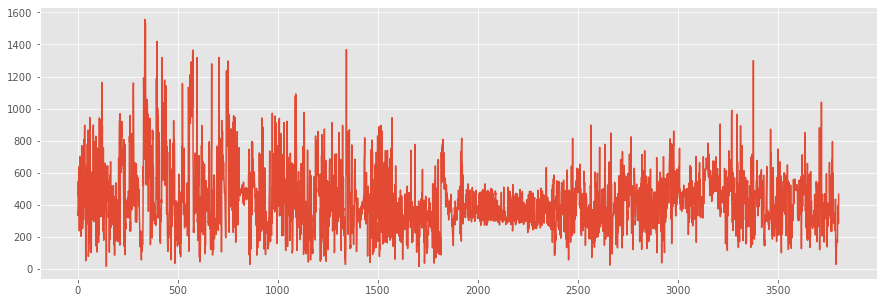

In [272]:
temp = df['Subcar_7']
temp.plot()

In [273]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + 5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [274]:
WINDOW_SIZE = 144
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((3658, 5, 1), (3658,))

In [275]:
x_train, y_train = X[:2000], y[:2000]
x_test, y_test = X[700:750], y[700:750]
x_val, y_val = X[750:], y[750:]
print('x_train set:', x_train.shape)
print('y_train set:', y_train.shape)
print('x_test set:', x_test.shape)
print('y_test:', y_test.shape)
print('x_val set:', x_val.shape)
print('y_val set:', y_val.shape)

x_train set: (2000, 5, 1)
y_train set: (2000,)
x_test set: (50, 5, 1)
y_test: (50,)
x_val set: (2908, 5, 1)
y_val set: (2908,)


In [276]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [277]:
model4 = Sequential()
model4.add(InputLayer((5, 1)))
model4.add(Conv1D(64, kernel_size=2))
model4.add(Conv1D(32, kernel_size=2))
model4.add(Flatten())
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 4, 64)             192       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 3, 32)             4128      
_________________________________________________________________
flatten_14 (Flatten)         (None, 96)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 776       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 5,105
Trainable params: 5,105
Non-trainable params: 0
_________________________________________________________________


In [278]:
cp = ModelCheckpoint('../save/model4/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

In [279]:
model4.fit(x_train,y_train, validation_data=(x_val, y_val),  epochs=10, callbacks=[early_stopping,cp])

Epoch 1/10
63/63 [==============================] - 1s 11ms/step - loss: 216385.7500 - mean_absolute_error: 403.2451 - val_loss: 110028.2812 - val_mean_absolute_error: 294.9494
Epoch 2/10
63/63 [==============================] - 1s 10ms/step - loss: 109729.5938 - mean_absolute_error: 268.3371 - val_loss: 50838.6094 - val_mean_absolute_error: 184.0666
Epoch 3/10
63/63 [==============================] - 1s 13ms/step - loss: 56174.7305 - mean_absolute_error: 176.1897 - val_loss: 27784.8633 - val_mean_absolute_error: 121.9262
Epoch 4/10
63/63 [==============================] - 1s 9ms/step - loss: 45070.8555 - mean_absolute_error: 153.1421 - val_loss: 25795.2598 - val_mean_absolute_error: 115.5594
Epoch 5/10
63/63 [==============================] - 1s 9ms/step - loss: 43828.3789 - mean_absolute_error: 150.4644 - val_loss: 25447.0117 - val_mean_absolute_error: 114.6517
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 42995.4062 - mean_absolute_error: 148.5681 - val_los

In [280]:
from tensorflow.keras.models import load_model
model1 = load_model('../save/model4/')

In [281]:
test_predictions1 = model1.predict(x_test).flatten()
test_results1 = pd.DataFrame(data={'Test predictions': test_predictions1, 'Actuals': y_test})
test_results1

,Test predictions,Actuals
0,463.227783,1318.891959
1,734.713440,427.907700
2,618.974854,308.974109
3,502.043854,375.431751
4,477.147491,315.995253
5,377.898834,323.487249
6,321.400848,281.128085
7,297.539703,346.161812
8,315.829376,294.266886
9,298.022736,291.756748


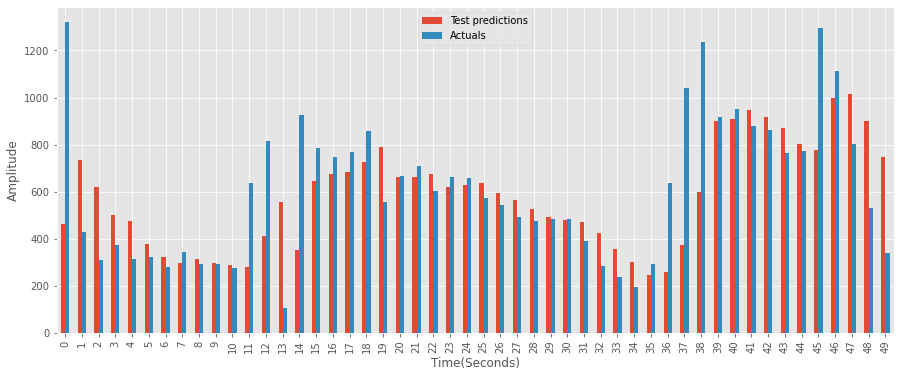

In [282]:
fig,ax = plt.subplots(figsize=(15,6))
test_results1.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

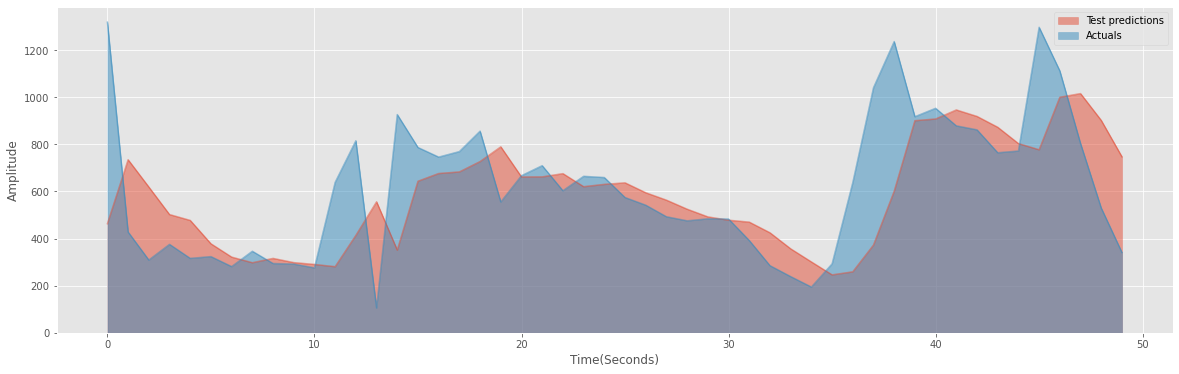

In [283]:
fig,ax = plt.subplots(figsize=(20,6))
test_results1.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

Text(0, 0.5, 'Amplitude')

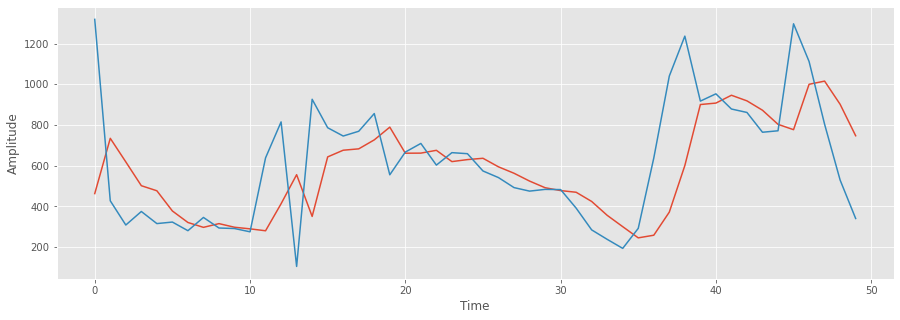

In [284]:
plt.plot(test_results1['Test predictions'])
plt.plot(test_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

In [285]:
model5 = Sequential()
model5.add(InputLayer((5, 1)))
model5.add(Conv1D(64, kernel_size=2,))
model5.add(Conv1D(32, kernel_size=2, ))
model5.add(Flatten())
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 4, 64)             192       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 3, 32)             4128      
_________________________________________________________________
flatten_15 (Flatten)         (None, 96)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 776       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 5,105
Trainable params: 5,105
Non-trainable params: 0
_________________________________________________________________


In [286]:
cp3 = ModelCheckpoint('../save/model5/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
model5.compile( optimizer=Adam(learning_rate=0.0001), 
                loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [287]:
model5.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks=[early_stopping, cp3])

Epoch 1/10
63/63 [==============================] - 1s 11ms/step - loss: 83469.3828 - mean_absolute_error: 222.0767 - val_loss: 30386.8633 - val_mean_absolute_error: 129.1891
Epoch 2/10
63/63 [==============================] - 1s 9ms/step - loss: 48286.5625 - mean_absolute_error: 159.9246 - val_loss: 27179.0293 - val_mean_absolute_error: 119.6008
Epoch 3/10
63/63 [==============================] - 1s 10ms/step - loss: 46676.1523 - mean_absolute_error: 156.9238 - val_loss: 26565.3066 - val_mean_absolute_error: 118.0709
Epoch 4/10
63/63 [==============================] - 1s 9ms/step - loss: 45503.5469 - mean_absolute_error: 154.7536 - val_loss: 25944.5742 - val_mean_absolute_error: 116.4444
Epoch 5/10
63/63 [==============================] - 1s 9ms/step - loss: 44366.4492 - mean_absolute_error: 152.4604 - val_loss: 25409.7188 - val_mean_absolute_error: 114.9904
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 43440.8555 - mean_absolute_error: 150.4784 - val_loss: 2

In [288]:
from tensorflow.keras.models import load_model
model5 = load_model('../save/model5/')

In [289]:
test_predictions2 = model5.predict(x_test).flatten()
test_results2 = pd.DataFrame(data={'Test predictions': test_predictions2, 'Actuals': y_test})
test_results2

,Test predictions,Actuals
0,442.609131,1318.891959
1,717.188904,427.907700
2,640.871826,308.974109
3,572.169678,375.431751
4,515.751343,315.995253
5,407.932190,323.487249
6,325.109985,281.128085
7,303.051483,346.161812
8,311.726990,294.266886
9,298.713562,291.756748


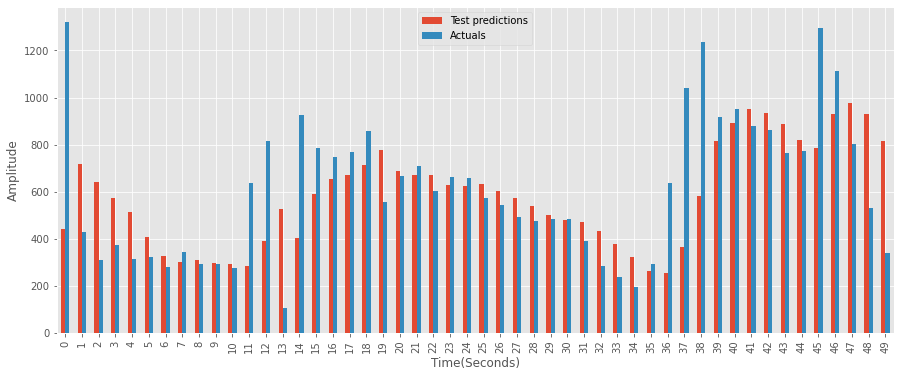

In [290]:
fig,ax = plt.subplots(figsize=(15,6))
test_results2.plot(kind='bar',ax=ax)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

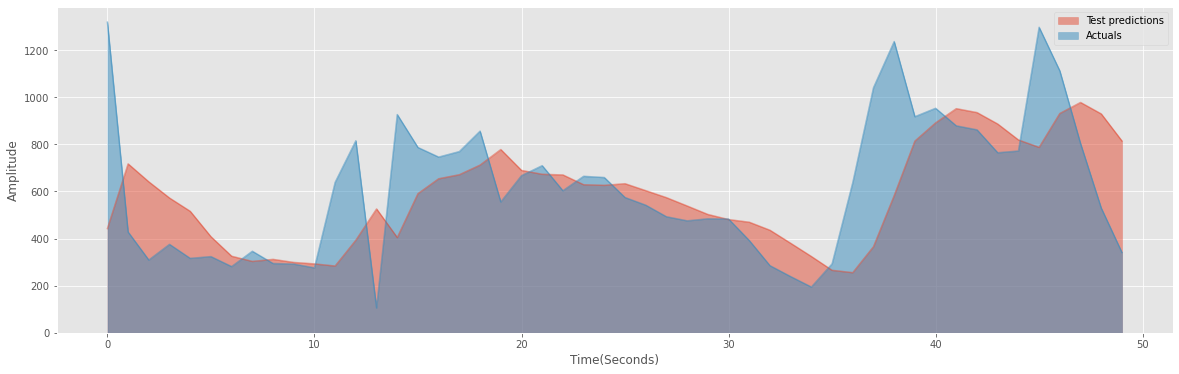

In [291]:
fig,ax = plt.subplots(figsize=(20,6))
test_results2.plot(kind='area',ax=ax,stacked=False)
ax.set_xlabel("Time(Seconds)")
ax.set_ylabel("Amplitude")
plt.show()

Text(0, 0.5, 'Amplitude')

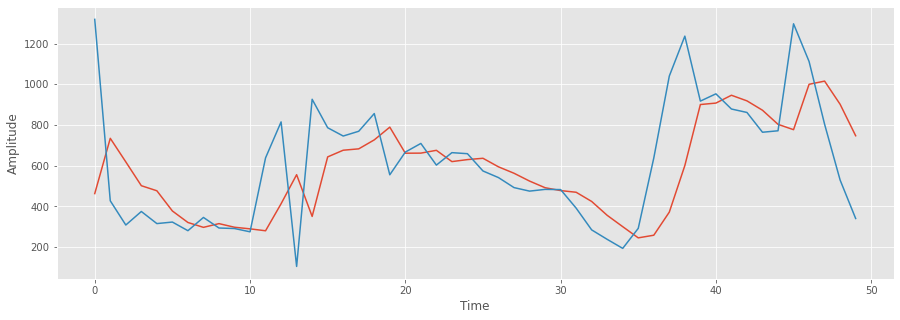

In [292]:
plt.plot(test_results1['Test predictions'])
plt.plot(test_results1['Actuals'])
plt.xlabel("Time")
plt.ylabel("Amplitude")

In [293]:
X = df.iloc[:, [7,10] ]
y = df.iloc[:, 9]

In [294]:
X.head()

,Subcar_6,Subcar_9
0,362.527240,353.793725
1,338.013313,319.820262
2,421.911128,441.279956
3,533.348854,562.694411
4,415.226444,458.423385


In [295]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [296]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2,random_state=100)

In [297]:
x_train1.head()

,Subcar_6,Subcar_9
2518,389.867926,363.323547
3093,483.467682,464.009698
3005,613.481866,605.324706
115,785.800229,753.050463
529,345.833775,330.024242


In [298]:
scaler = StandardScaler()
x_train1 = scaler.fit_transform(x_train1)

In [299]:
x_test1 = scaler.transform(x_test1)

In [300]:
scaler.mean_

array([424.24966958, 411.9004845 ])

In [301]:
# variance
scaler.scale_

array([202.35292646, 171.66761073])

In [302]:
x_train_scaled = scaler.transform(x_train1)

C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [303]:
# mean of standardize data
x_train_scaled.mean(axis=0)

array([-2.09658282, -2.3994071 ])

In [304]:
# scaled variance/ std
x_train_scaled.std(axis=0)

array([0.00494186, 0.00582521])